## <center> AstroStatistics and Cosmology - Homework 4

### <center> Lorenzo Cavezza 2130648

In [1]:
# Importing the necessary libraries
import time
import seaborn as sns
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal,norm
from scipy.linalg import cholesky
import pickle as pkl

### Exercise 7

Consider a bivariate Gaussian distribution $N (\mu, \Sigma)$, where $\mu = (4, 2)$, $\Sigma_{11} = 1.44$, $\Sigma_{22} = 0.81$, $\Sigma_{12} = \Sigma_{21} =  -0.702$. Assume that such distribution describes the posterior of two parameters $X_1$ and $X_2$ . Plot contours of this distribution and tell what are the boundaries of the $95\%$ credibile interval for each parameter, after marginalizing over the other. Tell how these boundaries change if, instead of marginalizing, we fix either parameter to a known value.

In [387]:
# Defining the mean and covariance matrix of the Gaussian distribution
mean = [4, 2]
covariance = np.array([[1.44,-0.702],[-0.702,0.81]])

In [388]:

x, y = np.mgrid[-2:10:0.1, -2:6:0.1]
pos = np.dstack((x, y))

# Computing the PDF of the multivariate Gaussian
rv = multivariate_normal(mean, covariance)
pdf = rv.pdf(pos)
pdf_perc = pdf/np.sum(pdf)*100

#Computing marginal distributions
x_marginal = np.sum(pdf_perc,axis=1)
x_marginal_norm = x_marginal/np.sum(x_marginal)
y_marginal = np.sum(pdf_perc,axis=0)
y_marginal_norm = y_marginal/np.sum(y_marginal)

#Computing fixed value distributions
x_max = np.argmax(np.max(pdf_perc,axis=1))
y_max = np.argmax(pdf_perc[x_max,:])
x_fixed = pdf_perc[:,y_max]
x_fixed_norm = x_fixed/np.sum(x_fixed) 
y_fixed = pdf_perc[x_max,:]
y_fixed_norm = y_fixed/np.sum(y_fixed) 

In [389]:
def margin_plotter(x,y,col,ax,ty,name): #Function to plot distributions on the marigins and CI
    ax.plot(x,y, linewidth=1.5,color=col,label=name)
    if ty=='y':
        pdf = x
        axis_values = y
    else:
        pdf = y
        axis_values = x

        
    sorted_pdf = np.sort(pdf)[::-1]
    cumulative_sum = np.cumsum(sorted_pdf)
    index = np.searchsorted(cumulative_sum, 0.95)
    value=sorted_pdf[index]
    differences = np.abs(pdf - value)
    closest_indices = np.argsort(differences)[:2]
    CI = axis_values[closest_indices]
    
    if ty=='y':
        ax.plot([0,pdf[closest_indices][0]],[CI[0],CI[0]],color=col)
        ax.plot([0,pdf[closest_indices][1]],[CI[1],CI[1]],color=col)
        ax.text(-0.025,CI[0]-0.07, np.round(CI[0],3),fontsize=10)
        ax.text(-0.025,CI[1]-0.07, np.round(CI[1],3),fontsize=10) 
    else:
        ax.plot([CI[0],CI[0]],[0,pdf[closest_indices][0]],color=col)
        ax.plot([CI[1],CI[1]],[0,pdf[closest_indices][1]],color=col)
        ax.text(CI[0]-0.15, -0.02, np.round(CI[0],3),fontsize=10)
        ax.text(CI[1]-0.15, -0.02, np.round(CI[1],3),fontsize=10)    

In [390]:
def plotter(x,y,pdf_perc,x_marginal_norm,x_fixed_norm,y_marginal_norm,y_fixed_norm,x_max,y_max,title):
    x_axis = x[:,0]
    y_axis = y[0,:]
    
    sns.set_style("white")
    g = sns.JointGrid(space=0,ratio=8,height=5)
    
    # Contour Plotting
    levels_perc = [99.7,95,80,68,50,33,15,5,0]
    flat_pdf = pdf_perc.flatten()
    sorted_pdf = np.sort(flat_pdf)[::-1]
    cumulative_sum = np.cumsum(sorted_pdf)
    differences = cumulative_sum[:, np.newaxis] - levels_perc
    indexes = [np.searchsorted(differences[:,i], 0) for i in range(np.shape(differences)[1])]
    levels=sorted_pdf[indexes]
    contour=g.ax_joint.contourf(x, y, pdf_perc, cmap='Reds',levels=levels)
    
    # Center cross plotting
    g.ax_joint.plot(x_axis, np.repeat(x[y_max][0],len(x_axis)),color='darkgreen')
    g.ax_joint.plot(np.repeat(x[x_max][0],len(y_axis)),y_axis,color='darkgreen')
    
    # Arrows Plotting
    arrow_length = 0.4 # Length of the perpendicular arrows
    for i in range(10, len(x_axis), 20):
        g.ax_joint.annotate('', xy=(x_axis[i], y_axis[y_max] + arrow_length),
        xytext=(x_axis[i], y_axis[y_max]),
        arrowprops=dict(facecolor='darkgreen', edgecolor='darkgreen', arrowstyle='->', lw=0.6))
    for i in range(10, len(y_axis), 20):
        g.ax_joint.annotate('', xy=(x_axis[x_max] + arrow_length, y_axis[i]),
        xytext=(x_axis[x_max], y_axis[i]),
        arrowprops=dict(facecolor='darkgreen', edgecolor='darkgreen', arrowstyle='->', lw=0.6))
        
    # Colorbar plotting
    g.fig.subplots_adjust(right=0.82)
    cbar_ax = g.fig.add_axes([0.85, 0.1, 0.02, 0.8])
    cbar = g.fig.colorbar(contour, cax=cbar_ax, orientation='vertical')
    cbar.set_label("Percentage (%)", fontsize=12)
    cbar.set_ticklabels(levels_perc) 
    
    # Margin plotting
    margin_plotter(y_marginal_norm,y_axis,'red',g.ax_marg_y,'y','Marginal PDF')
    margin_plotter(y_fixed_norm,y_axis,'darkgreen',g.ax_marg_y,'y','Fixed PDF')
    margin_plotter(x_axis,x_marginal_norm,'red',g.ax_marg_x,'x','Marginal PDF')
    margin_plotter(x_axis,x_fixed_norm,'darkgreen',g.ax_marg_x,'x','Fixed PDF')
    
    # Formatting
    g.fig.set_figwidth(10)
    g.ax_joint.set_title(title,fontsize=19,pad=50)
    g.ax_joint.title.set_position((0.65, 0.65))
    g.ax_joint.set_xlabel("$X_1$")
    g.ax_joint.set_ylabel("$X_2$")
    g.ax_joint.grid(True)
    g.ax_marg_x.legend(fontsize=9,frameon=False,loc='best')
    g.ax_joint.text(8,5, "$X_{{max}}=({0},{1})$".format(round(x[x_max][0],2),round(x[y_max][0],2)), size=12,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   )
         )

    plt.show()


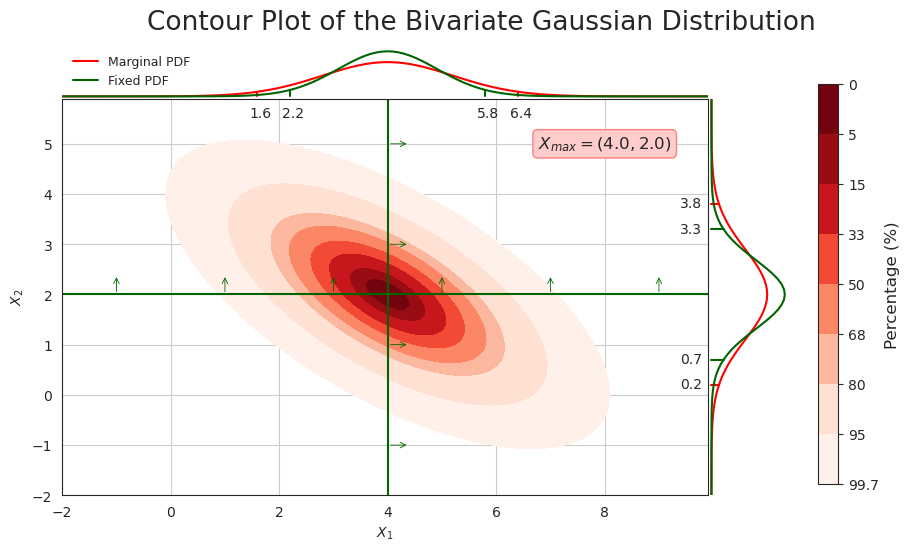

In [391]:
title = "Contour Plot of the Bivariate Gaussian Distribution"
plotter(x,y,pdf_perc,x_marginal_norm,x_fixed_norm,y_marginal_norm,y_fixed_norm,x_max,y_max,title)

The darker shades of red represent areas that contains a smaller and smaller percentage of the probability mass of the distribution, so for example the last ellipse represents the $3\sigma$ contour and so on. The fixed values pdfs are computed along the green lines.

Now, re-obtain the same boundaries via Monte Carlo sampling of the posterior, in three ways: (In all cases, do not rely on pre-made code, but write your own (i.e., you can surely use libraries to generate known distributions, do Cholesky decomposition, and so on, but you should not use a pre-made library with a command like ”Gibbs-sampling”). In all cases, provide final contour plots, and marginalized posteriors. In the MCMC analysis, produce also trace plots to test for convergence of the chains)

**a)** By directly drawing values of $\left(X_1 , X_2 \right)$, by mean of a Cholesky decomposition of the covariance (check in the literature how to do this):

#### Solution

In [394]:
nsamples = 10000000
sampled = np.random.normal(loc=0, scale=1, size=(nsamples, 2))
col = cholesky(covariance)
gen = np.tile(mean,(nsamples,1)) + np.dot(sampled,col)

In [395]:
x, y = np.mgrid[-2:10:0.1, -2:6:0.1]

x_axis = x[:,0]
y_axis = y[0,:]
pdf, _, _ = np.histogram2d(gen[:, 0], gen[:, 1], bins=[x_axis, y_axis], density=True)

#Compute marginal distributions
x_marginal = np.sum(pdf,axis=1)
x_marginal_norm = x_marginal/np.sum(x_marginal)
y_marginal = np.sum(pdf,axis=0)
y_marginal_norm = y_marginal/np.sum(y_marginal)

#Compute fixed value distributions
x_max = np.argmax(np.max(pdf,axis=1))
y_max = np.argmax(pdf[x_max,:])
x_fixed = pdf[:,y_max]
x_fixed_norm = x_fixed/np.sum(x_fixed) 
y_fixed = pdf[x_max,:]
y_fixed_norm = y_fixed/np.sum(y_fixed) 

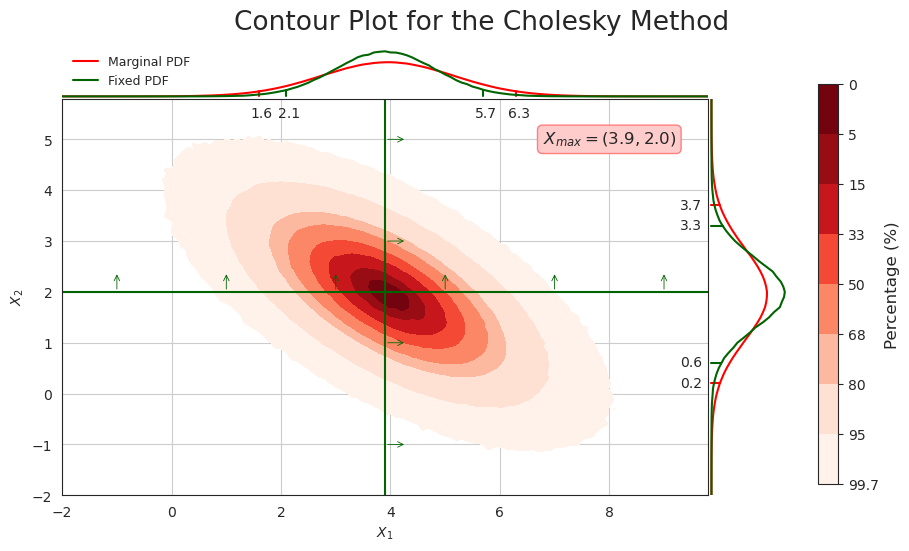

In [397]:
title = "Contour Plot for the Cholesky Method"
plotter(x[:-1,:-1],y[:-1,:-1],pdf,x_marginal_norm,x_fixed_norm,y_marginal_norm,y_fixed_norm,x_max,y_max,title)

**b)** Via Metropolis-Hastings sampling of the posterior:

#### Solution

In order to get good plots I compute the chains over a large number of epochs once and save them on a pickle file that I upload when needed (mind the code blocks where the chains are computed take a very long time).

In [120]:
def MHMCMC(post,iterations):
    
    # Conditions to generate the chains far away from the center of the distribution
    c=True
    while (c==True):
        x = np.random.uniform(0, 8)
        y = np.random.uniform(-2,6)
        
        if (1 <= x <= 7 and -1 <= y <= 5):
            c=True
        else:
            c=False
            
    x = np.array([x,y])
    mcov = np.array([[0.5,0],[0,0.5]])
    accepted = np.empty((iterations, 2))

    for i in range(iterations):
        proposed = np.random.multivariate_normal(x,mcov)
        acc = post.pdf(proposed)/post.pdf(x)
        if acc>=1 or np.random.rand() <= acc:
            x = proposed
        accepted[i]=x
    
    return (accepted)
     
def chains(nchain,posterior,iterations):
    chains = np.empty((nchain,iterations, 2))
    
    for i in range(nchain):
        chains[i]=MHMCMC(posterior,iterations)
    return chains
        
x, y = np.mgrid[-2:10:0.1, -2:6:0.1]
pos = np.dstack((x, y))

posterior = multivariate_normal(mean, covariance)

chains = chains(4,posterior,10000000)

In [123]:
# Saving the chains to run the chains just once
with open('chains.pkl', 'wb') as f: 
    pkl.dump(chains, f)

In [7]:
# Loading the chains
with open('chains.pkl', 'rb') as f:
    chains = pkl.load(f)

In [403]:
title_MH = "Metropolis - Hastings"
x, y = np.mgrid[-2:10:0.1, -2:6:0.1]

x_axis = x[:,0]
y_axis = y[0,:]
pdf, _, _ = np.histogram2d(chains[0][:, 0], chains[0][:, 1], bins=[x_axis, y_axis], density=True)

#Compute marginal distributions
x_marginal = np.sum(pdf,axis=1)
x_marginal_norm = x_marginal/np.sum(x_marginal)
y_marginal = np.sum(pdf,axis=0)
y_marginal_norm = y_marginal/np.sum(y_marginal)

#Compute fixed value distributions
x_max = np.argmax(np.max(pdf,axis=1))
y_max = np.argmax(pdf[x_max,:])
x_fixed = pdf[:,y_max]
x_fixed_norm = x_fixed/np.sum(x_fixed) 
y_fixed = pdf[x_max,:]
y_fixed_norm = y_fixed/np.sum(y_fixed) 

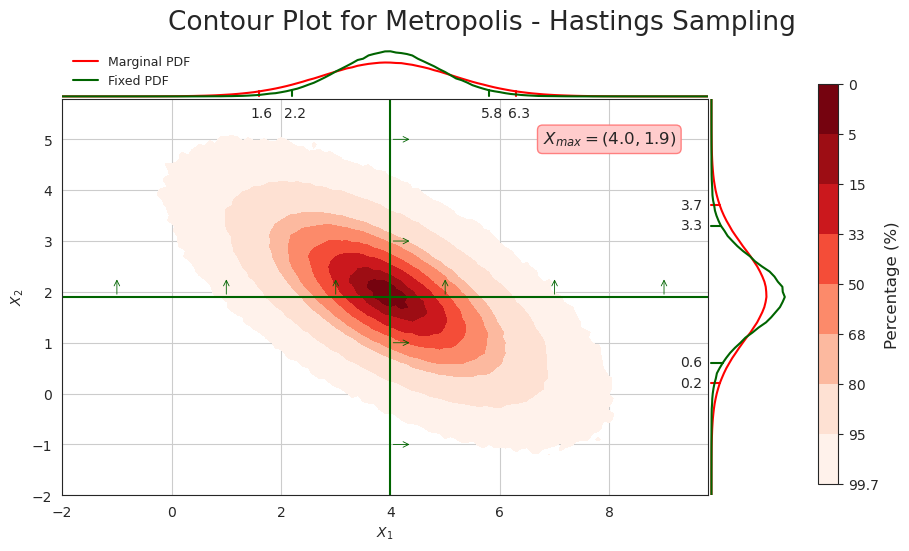

In [404]:
title = "Contour Plot for {0} Sampling".format(title_MH)
plotter(x[:-1,:-1],y[:-1,:-1],pdf,x_marginal_norm,x_fixed_norm,y_marginal_norm,y_fixed_norm,x_max,y_max,title)

I ran 4 chains starting in random places far from the distribution's peak in order to better see their behaviour:

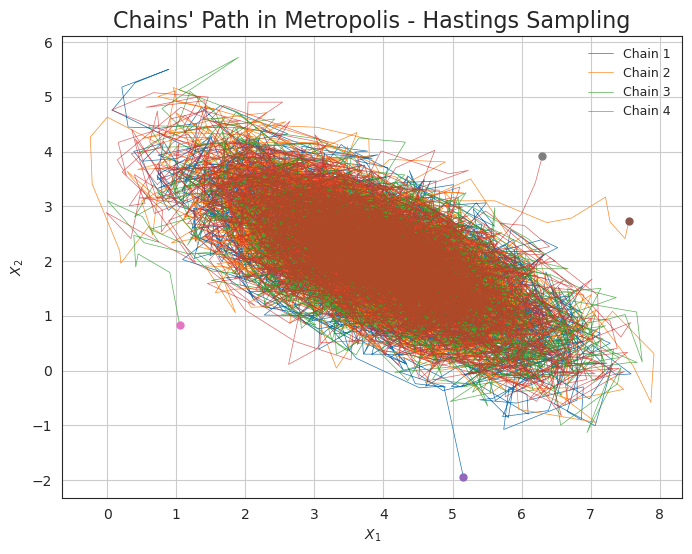

In [405]:
def plot_behaviour(chains, title):
    
    fig,ax = plt.subplots(figsize=(8,6))
    for i in range(len(chains)):
        ax.plot(chains[i][:5000,0],chains[i][:5000,1],lw=0.5,label='Chain {0}'.format(i+1),alpha=1-0.1*i)
    for i in range(len(chains)):
        ax.plot(chains[i][0,0],chains[i][0,1],marker='o',markersize=5)

    ax.set_title("Chains' Path in {0} Sampling".format(title),fontsize=16)
    ax.set_xlabel("$X_1$")
    ax.set_ylabel("$X_2$")
    ax.grid(True)
    ax.legend(fontsize=9,frameon=False,loc='best')
    plt.show()

plot_behaviour(chains, title_MH)


Even if the chains start very far from the peak the sampled area roughly corresponds to the $3\sigma$ contour computed earlier.

In [377]:
def plot_trace(chain,N):
    
    n_samples, n_params = chain.shape
    param_names = ["$X_{0}$".format(i+1) for i in range(n_params)]
    
    fig, axes = plt.subplots(n_params, 1, figsize=(10, 2.5 * n_params), sharex=True)
    
    if n_params == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        ax.plot(chain[:N, i], lw=0.5)
        ax.plot(np.repeat(np.mean(chain[:,i]),N),color='red')
        ax.set_title("Trace plot for {0}".format(param_names[i]))
        ax.set_ylabel(param_names[i])
        ax.grid(True)
    
    axes[-1].set_xlabel("Iterations")
    plt.tight_layout()
    plt.show()

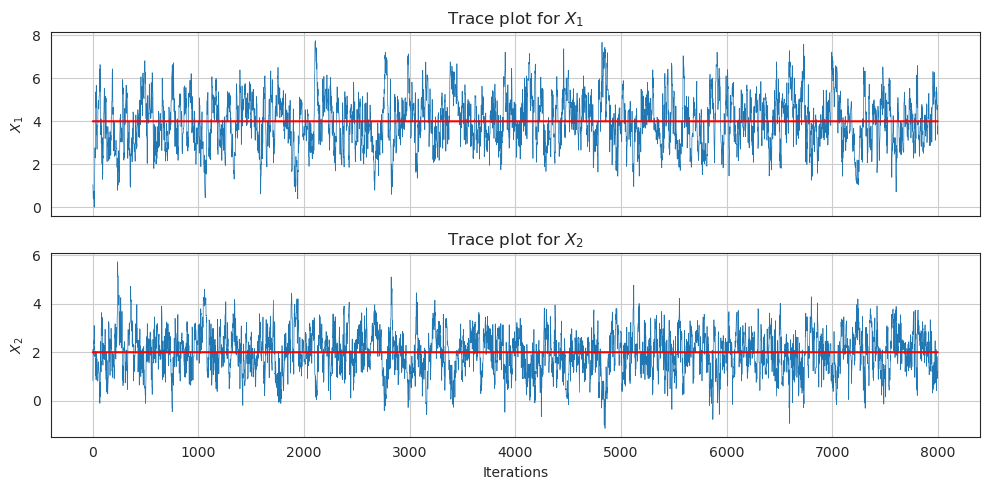

In [378]:
plot_trace(chains[2],8000)

In [327]:
def traces (chain):
    traces = []
    for i in range(len(chain)):
        pdf_values = multivariate_normal.pdf(chain[i], mean=mean, cov=np.linalg.inv(covariance))
        neg_log_probs = -np.log(pdf_values)
        trace_values_norm = np.cumsum(neg_log_probs/ np.arange(1, len(chain[i]) + 1)) 
        traces.append(trace_values_norm)
    return (np.array(traces))

In [425]:
def plot_log_trace(traces,title):
    
    fig, ax = plt.subplots(figsize=(10, 3))
    for i in range(len(traces)):
        ax.plot(traces[i], label='Chain {0}'.format(i+1))
        
    ax.set_title("Trace plots in {0} Sampling".format(title),fontsize=12)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("$Tr[-\log{\mathcal{P}}]$")
    ax.legend(loc='best')
    ax.grid(True)

    plt.show()

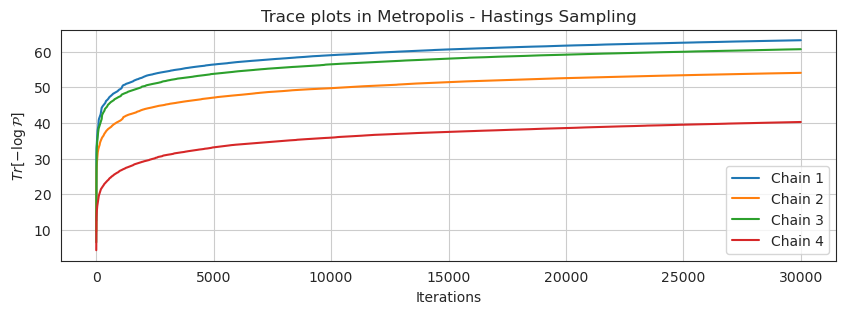

In [426]:
traces_MH = traces(chains[:,:30000,:])
plot_log_trace(traces_MH,title_MH)

In order to assess the burn in phase to discard and the good mixing of the chains we perform a Gelman - Rubin test:

In [105]:
def R(chains):
    nchains = len(chains)
    niter = len(chains[0])
    theta_j = np.zeros((nchains,2))
    w_j = np.zeros((nchains,2,2))
    for i in range(nchains):
        #print(np.shape(theta_j[i,:]))
        theta_j[i,:] = np.mean(chains[i],axis=0)
        w_j[i,:,:] = np.cov(chains[i], rowvar=False)
    thetatot = np.mean(np.mean(chains[:][:100,:],axis=1),axis=0)
    W = np.mean(w_j,axis=0)
    B=0
    for i in range(nchains):
        B+=(theta_j[i]-thetatot)**2
    B*=niter/(nchains-1)
    V = (niter - 1)/niter*W + (nchains + 1)/nchains*B/niter
    R = np.dot(V,np.linalg.inv(W))
    return (R)

def Rs(chains):
    niter = len(chains[0])
    R_tot = []
    samples_index = np.unique(np.logspace(1, 7, 1000, dtype=int))
    for i in samples_index:
        R_tot.append(R(chains[:,:i,:]))
    return (samples_index, np.array(R_tot))


In [193]:
samples_1, R_tot_1 = Rs(chains)

In [408]:
def convergence_plot(s, R, point, title):
    R11 = R[:,0,0]
    R22 = R[:,1,1]
    fig,ax = plt.subplots(figsize = (10,6))
    ax.plot(s, R11-1, color='red', label = '$R_{11}$')
    ax.plot(s, R22-1, color='blue',label = '$R_{22}$')
    ax.axhline(0.1, color = 'green',linestyle='dashed')
    index = np.argmin(np.abs(R11 - 1 - 0.1))
    ax.axvline(samples[index], color = 'green',linestyle='dashed')
    ax.text(samples[index]+point[0], point[1],samples[index]  ,fontsize=10, color ='green')
    ax.set_title('Gelman - Rubin Test in {0} Sampling'.format(title),fontsize=16)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('$R_{ii}-1$')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(loc='best')
    ax.grid(True)
    

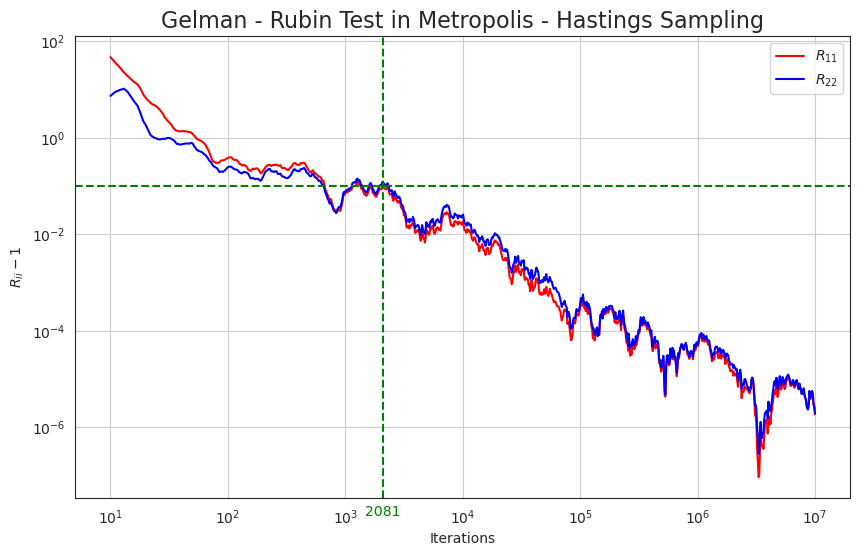

In [409]:
convergence_plot(samples_1, R_tot_1, [-600,0.15e-7], title_MH)

As we can see the $00$ and $11$ elements of the Gelman-Rubin estimator $R$ converge rather quickly towards $1$, furthermore they go below $1.1$ after about $2000$ iterations, indicating the burn-in phase ends roughly there. Since the value is pretty flat there I take $5000$ as the final point of burn-in. Below is the trace plots with the burn-in phase subtracted:

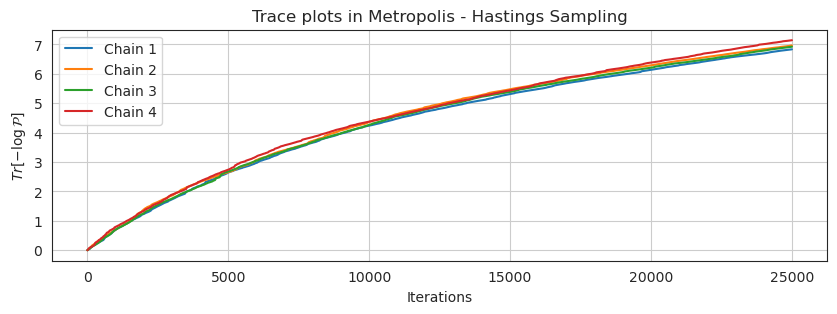

In [427]:
plot_log_trace(traces_MH[:,5000:]-np.reshape(traces_MH[:,5000],(4,1)),title_MH)

**c)** Via Gibbs sampling of the posterior:

#### Solution

In [368]:
title_G = 'Gibbs'

def GibbsMCMC(iterations):
    
    # Conditions to generate the chains far away from the center of the distribution
    c=True
    while (c==True):
        x = np.random.uniform(0, 8)
        y = np.random.uniform(-2,6)
        
        if (1 <= x <= 7 and -1 <= y <= 5):
            c=True
        else:
            c=False
                
    accepted = np.empty((iterations, 2))
    accepted[0,0] = x
    accepted[0,1] = y

    for i in range(iterations-1):
        updated = np.random.randint(0,2)
        not_updated = (updated + 1)%2
        
        inv_covariance = np.linalg.inv(covariance)
        prop_sigma = 1./np.sqrt(inv_covariance[updated,updated])
        prop_mean = mean[updated]-inv_covariance[updated,not_updated]/inv_covariance[updated,updated]*(accepted[i,not_updated]-mean[not_updated])
        proposed = np.random.normal(prop_mean,prop_sigma)
        
        accepted[i+1,updated] = proposed
        accepted[i+1,not_updated] = accepted[i,not_updated]
     
    return (accepted)

def chains_gibbs(nchain, iterations):
    chains = np.empty((nchain,iterations, 2))
    for i in range(nchain):
        chains[i]=GibbsMCMC(iterations)
    return chains


Again I run the chains for a long time once and save them on a pickle. Therefore mind the following code cell takes a long time to compute.

In [75]:
chain_g = chains_gibbs(4,10000000)

In [76]:
# Saving the chains to run the chains just once
with open('chaing.pkl', 'wb') as f: 
    pkl.dump(chain_g, f)

In [110]:
# Loading the chains
with open('chaing.pkl', 'rb') as f:  # open a text file
    chain_g = pkl.load(f) # serialize the list

In [401]:
x, y = np.mgrid[-2:10:0.1, -2:6:0.1]

x_axis = x[:,0]
y_axis = y[0,:]
pdf, _, _ = np.histogram2d(chain_g[0][:, 0], chain_g[0][:, 1], bins=[x_axis, y_axis], density=True)

#Compute marginal distributions
x_marginal = np.sum(pdf,axis=1)
x_marginal_norm = x_marginal/np.sum(x_marginal)
y_marginal = np.sum(pdf,axis=0)
y_marginal_norm = y_marginal/np.sum(y_marginal)

#Compute fixed value distributions
x_max = np.argmax(np.max(pdf,axis=1))
y_max = np.argmax(pdf[x_max,:])
x_fixed = pdf[:,y_max]
x_fixed_norm = x_fixed/np.sum(x_fixed) 
y_fixed = pdf[x_max,:]
y_fixed_norm = y_fixed/np.sum(y_fixed) 

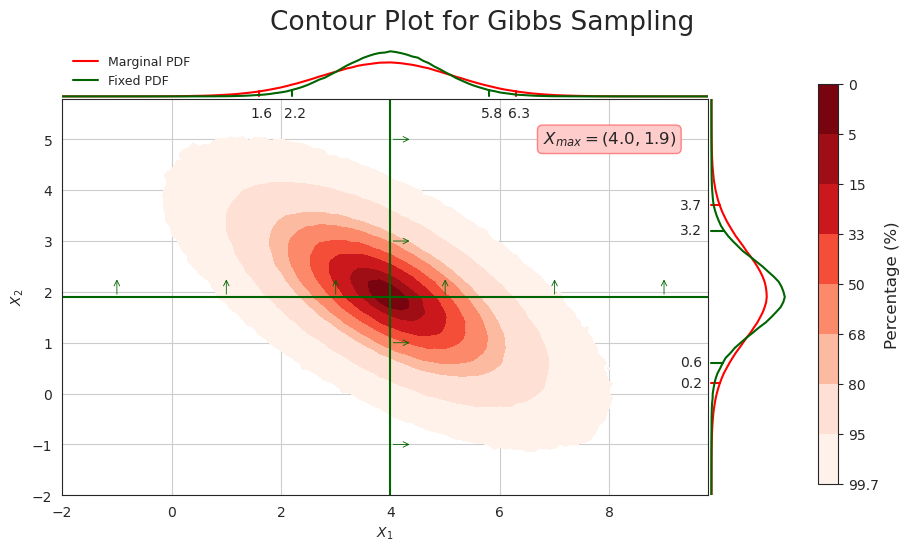

In [402]:
title = "Contour Plot for {0} Sampling".format(title_G)
plotter(x[:-1,:-1],y[:-1,:-1],pdf,x_marginal_norm,x_fixed_norm,y_marginal_norm,y_fixed_norm,x_max,y_max,title)

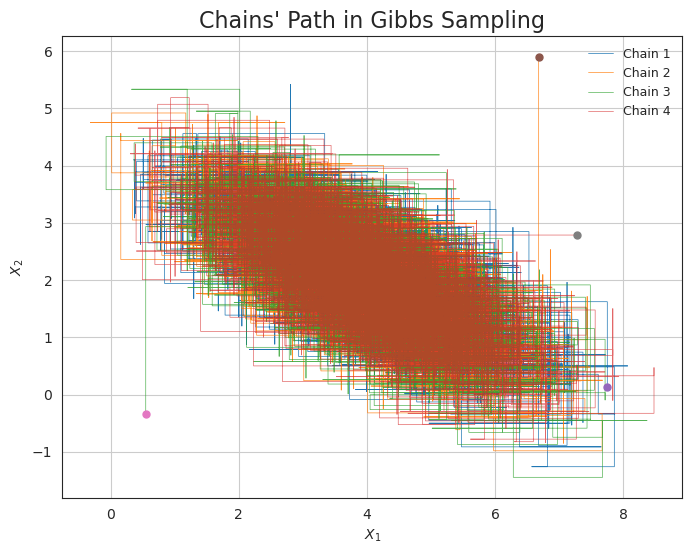

In [410]:
plot_behaviour(chain_g, title_G)

As before we see that the chains converge quickly to the $3\sigma$ contour area. The characteristic Gibbs behaviour can be observed.

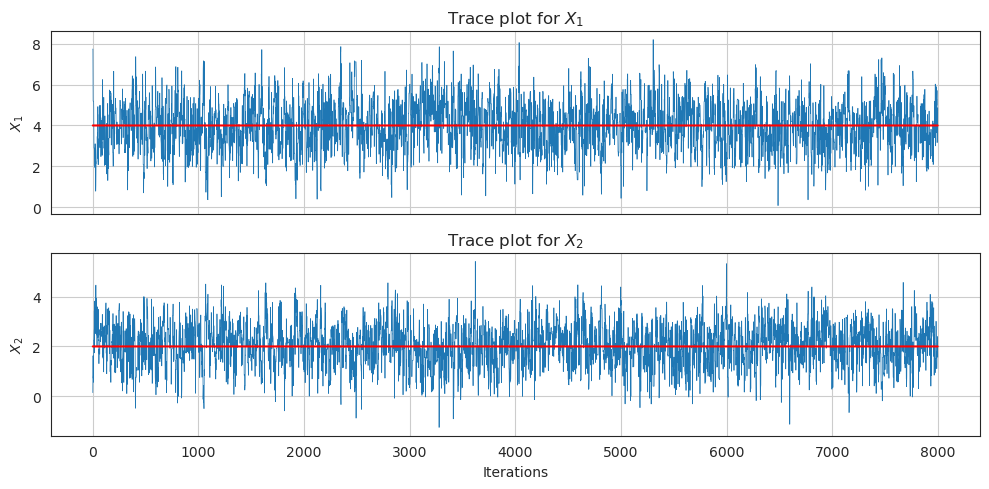

In [381]:
plot_trace(chain_g[0],8000)

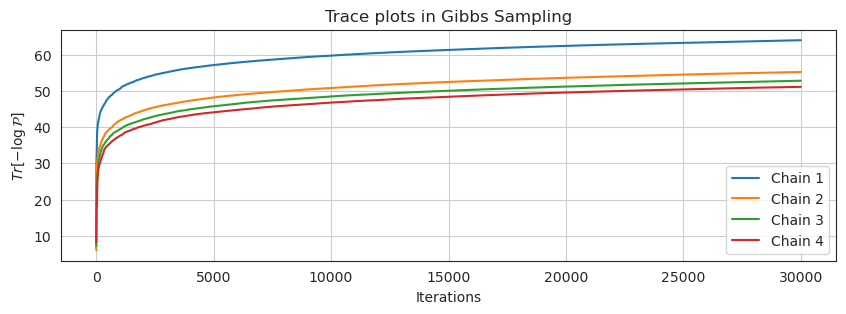

In [428]:
traces_G = traces(chain_g[:,:30000,:])
plot_log_trace(traces_G, title_G)

We perform the same test as before:

In [226]:
samples_2, R_tot_2 = Rs(chain_g)

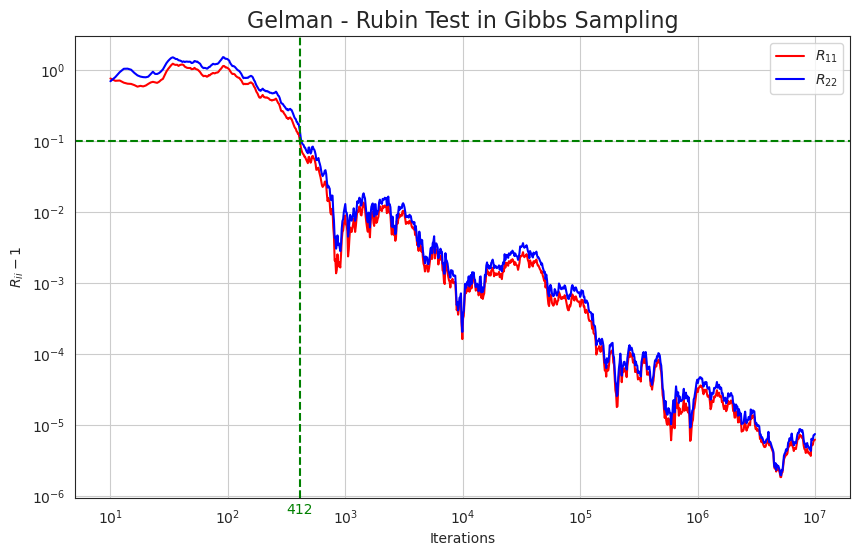

In [411]:
convergence_plot(samples_2, R_tot_2, [-100,0.55e-6], title_G)

Here convergence is quicker as the burn-in phase ends roughly after $500$ iterations:

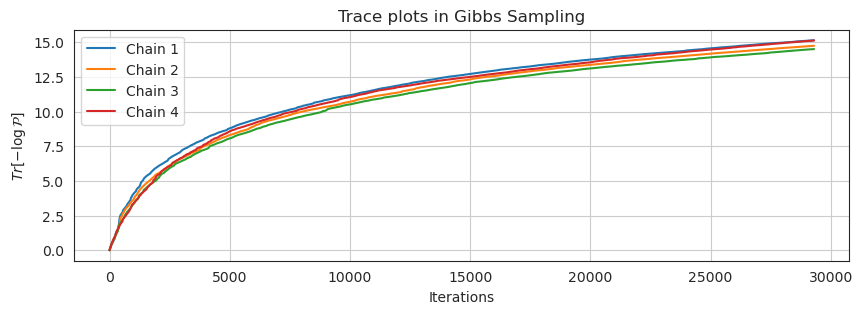

In [429]:
plot_log_trace(traces_MH[:,700:]-np.reshape(traces_MH[:,700],(4,1)), title_G)